## ResNet

The Residual Net (https://arxiv.org/pdf/1512.03385.pdf) by He, et al. (2015) which is a novel paper that introduced a new convolutional neural network structure called ResNet. The main different is the building block of this network: residual building block (also called skip connection). By combining the original input x together with the output, the gradients could be better passed and thus enable easier training process for larger and deeper neural networks.

<br/>

<img src="./images/resnet_block.png"/>

This is done by a function $y = F(x, {W_{i}}) + x$

In [25]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torch.nn import functional as F
import matplotlib.pyplot as plt
import math

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)
device

device(type='cuda')

In [3]:
batch_size = 64

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

loss_list = []
accuracy_list = []
epoch_list = []

train_data = datasets.CIFAR10(root='./resources/cifar10', train=True, transform=transform_train, download=True)
test_dataset = datasets.CIFAR10(root='./resources/cifar10', train=False, transform=transform_test, download=True)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, generator=torch.Generator(device=device))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, generator=torch.Generator(device=device))

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# CIFAR-10 dataset consists of 32 * 32 RGB channel images.
# because batch size is 64, the inputs shape should be (batch, channel, height, width), which is (64, 3, 32, 32)

inputs, classes = next(iter(train_loader))
inputs.shape, classes.shape

(torch.Size([64, 3, 32, 32]), torch.Size([64]))

## The Identity Mapping by Shortcuts

The residual nets adopt identity mappings that can let the gradients pass more conveniently and also have some other benefits.

$y = F(x, {W_{i}}) + x$

The output dimension after doing a convolution computation ($F(x, {W_{i}})$) should be the same as the dimension of $x$, and the final result of y is computed by element-wise addition of these two and then pass into the relu function.

In [5]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.channels = channels
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)

    def forward(self, x):
        print("x", x.shape)
        y = F.relu(self.conv1(x))
        print("y1", y.shape)
        y = self.conv2(y)
        print("y2", y.shape)
        return F.relu(x + y)

In [6]:
rand_x = torch.zeros(size=(1, 3, 32, 32))
tst_rs_block = ResidualBlock(3)
rand_res_x = tst_rs_block(rand_x)
rand_res_x.shape

x torch.Size([1, 3, 32, 32])
y1 torch.Size([1, 3, 32, 32])
y2 torch.Size([1, 3, 32, 32])


torch.Size([1, 3, 32, 32])

## The Identity Mapping changing channel

When channel changes, we do a 1x1 convolution with stride 2 to achieve the match of output size (see JumpChannelResidualBlock) (we must operate on x in order to keep the x as same dimension as output of $F(x, W_{i})$. Also, we see difference between JumpChannelResidualBlock and ResidualBlock in parameters, this is because in the original paper when the dimension is increased, the output size (height * width) is reduced and there is a convolutional block of stride 2 each time.

<br/>
<img src="./images/resnet_jump.png"/>

Here we can observe that when the network jumps from 64 channels of output size 56 * 56 to 128 channels of output size 28 * 28, the channel # is doubled and output size width or height is halfed. We compute the padding required based on this.

In [7]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)

    def forward(self, x):
        y = F.relu(self.conv1(x))
        y = self.conv2(y)
        return F.relu(x + y)

class JumpChannelResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, in_size, out_size):
        super(JumpChannelResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=math.ceil(2 * out_size + 1 - in_size), stride=2)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.pad_channel_1x1_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2)

    def forward(self, x):
        y = F.relu(self.conv1(x))
        y = self.conv2(y)
        x = self.pad_channel_1x1_conv(x)
        return F.relu(x + y)

## ResNet 18

Here we implement an example of ResNet 18. See the layer settings in the below chart from the original ResNet paper (https://arxiv.org/pdf/1512.03385.pdf)
<br/>

<img src="./images/resnet_layer.png"/>

In [8]:
# Assume square images, height=width

class ResNet18(nn.Module):
    def __init__(self, in_height, in_channel, num_out_classes):
        super(ResNet18, self).__init__()
        self.in_height = in_height
        self.in_channel = in_channel

        self.conv1 = nn.Conv2d(in_channels=in_channel, out_channels=64, kernel_size=7, stride=2, padding=math.ceil((229-in_height) / 2))

        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.conv2_1 = ResidualBlock(channels=64)
        self.conv2_2 = ResidualBlock(channels=64)

        self.conv3_1 = JumpChannelResidualBlock(in_channels=64, out_channels=128, in_size=56, out_size=28)
        self.conv3_2 = ResidualBlock(channels=128)

        self.conv4_1 = JumpChannelResidualBlock(in_channels=128, out_channels=256, in_size=28, out_size=14)
        self.conv4_2 = ResidualBlock(channels=256)

        self.conv5_1 = JumpChannelResidualBlock(in_channels=256, out_channels=512, in_size=14, out_size=7)
        self.conv5_2 = ResidualBlock(channels=512)

        self.pool2 = torch.nn.AvgPool2d(kernel_size = 7)  # global average pooling on 512 dimensions: average every 7 * 7 pixels on each dimension to
        # a single pixel, so 512 * 7 * 7 -> 512

        self.fc1 = nn.Linear(512, 1000)
        self.fc2 = nn.Linear(1000, num_out_classes)


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.conv2_1(x)
        x = self.conv2_2(x)
        x = self.conv3_1(x)
        x = self.conv3_2(x)
        x = self.conv4_1(x)
        x = self.conv4_2(x)
        x = self.conv5_1(x)
        x = self.conv5_2(x)
        x = self.pool2(x)
        x = x.view(-1, 512)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [9]:
# Run a test example

rand_x2 = torch.zeros(size=(1, 3, 32, 32))
tst_res18 = ResNet18(32, 3, num_out_classes=10)
tst_res18_out1 = tst_res18(rand_x2)
tst_res18_out1.shape

torch.Size([1, 10])

In [10]:
model = ResNet18(in_height=32, in_channel=3, num_out_classes=10)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [11]:
def train(epoch):
    running_loss = 0.0
    for batch_index, data in enumerate(train_loader, 0):
        inputs, target = data
        inputs, target = inputs.to(device), target.to(device)
        optimizer.zero_grad()

        # forward, backward, update
        outputs = model(inputs)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if batch_index % 300 == 299:
            print('[%d, %d] loss: %.3f' % (epoch + 1, batch_index + 1, running_loss / 300))
            running_loss = 0.0


def run_test_sets():
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicts = torch.max(outputs.data, dim=1)
            total += labels.size(0)
            correct += (predicts == labels).sum().item()

    print('Accuracy on test sets: %d%%' % (100 * correct / total))

In [12]:
for epoch in range(20):
    train(epoch)
    run_test_sets()

[1, 300] loss: 2.087
[1, 600] loss: 1.891
Accuracy on test sets: 33%
[2, 300] loss: 1.646
[2, 600] loss: 1.567
Accuracy on test sets: 46%
[3, 300] loss: 1.440
[3, 600] loss: 1.356
Accuracy on test sets: 54%
[4, 300] loss: 1.260
[4, 600] loss: 1.215
Accuracy on test sets: 59%
[5, 300] loss: 1.150
[5, 600] loss: 1.133
Accuracy on test sets: 61%
[6, 300] loss: 1.080
[6, 600] loss: 1.058
Accuracy on test sets: 63%
[7, 300] loss: 1.020
[7, 600] loss: 0.999
Accuracy on test sets: 67%
[8, 300] loss: 0.963
[8, 600] loss: 0.955
Accuracy on test sets: 66%
[9, 300] loss: 0.916
[9, 600] loss: 0.943
Accuracy on test sets: 68%
[10, 300] loss: 0.897
[10, 600] loss: 0.898
Accuracy on test sets: 69%
[11, 300] loss: 0.864
[11, 600] loss: 0.877
Accuracy on test sets: 70%
[12, 300] loss: 0.841
[12, 600] loss: 0.845
Accuracy on test sets: 70%
[13, 300] loss: 0.821
[13, 600] loss: 0.825
Accuracy on test sets: 71%
[14, 300] loss: 0.808
[14, 600] loss: 0.799
Accuracy on test sets: 73%
[15, 300] loss: 0.787
[1

In [56]:
inputs, classes = next(iter(test_loader))
inputs, classes = inputs.to(device), classes.to(device)
inputs.shape, classes.shape

(torch.Size([64, 3, 32, 32]), torch.Size([64]))

In [57]:
model.eval()
model_preds = model(inputs)
model_preds.shape

torch.Size([64, 10])

In [58]:
_, predicts = torch.max(model_preds.data, dim=1)
predicts.shape

torch.Size([64])

In [59]:
# Then we can compare the predicted from model and the real labels

total_classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def see_one_comparison(x, y, predictions, index):
    x = x[index]
    y = y[index]
    prediction = predictions[index]

    print(f"Real Label: {total_classes[int(y)]} predicted label: {total_classes[int(prediction)]}")

    x = x.squeeze(0)
    print(x.shape)
    x = x.permute(1, 2, 0)  # (3, 32, 32) -> (32, 32, 3)
    print(x.shape)
    plt.imshow(x.cpu().detach().numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Real Label: cat predicted label: cat
torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


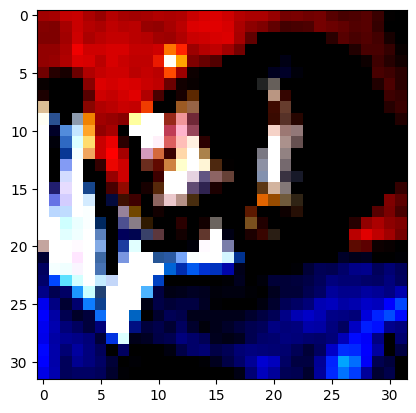

In [60]:
see_one_comparison(inputs, classes, predicts, 0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Real Label: ship predicted label: ship
torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


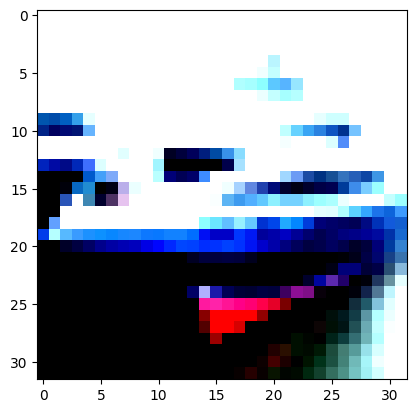

In [61]:
see_one_comparison(inputs, classes, predicts, 1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Real Label: ship predicted label: ship
torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


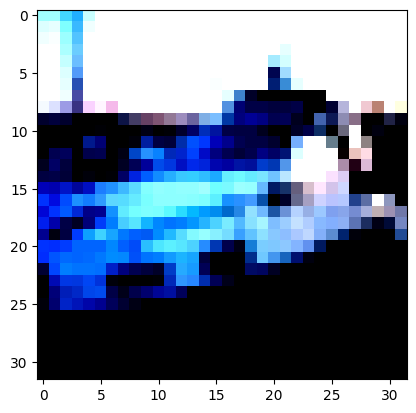

In [62]:
see_one_comparison(inputs, classes, predicts, 2)